In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
from utils.radam import *
from utils.lookahead import *
from utils.weight_init import *
from utils.plot_grad_flow import *

In [4]:
# Read data
df_creat = pd.read_csv('data/T_creatinine.csv')
df_dbp = pd.read_csv('data/T_DBP.csv')
df_glcs = pd.read_csv('data/T_glucose.csv')
df_hgb = pd.read_csv('data/T_HGB.csv')
df_ldl = pd.read_csv('data/T_ldl.csv')
df_sbp = pd.read_csv('data/T_SBP.csv')
df_meds = pd.read_csv('data/T_meds.csv')
df_stg = pd.read_csv('data/T_stage.csv')
df_dem = pd.read_csv('data/T_demo.csv')

In [6]:
#Create idx mapping for ease
df2idx = {0: df_creat,
         1: df_dbp,
         2: df_glcs,
         3: df_hgb,
         4: df_ldl,
         5: df_sbp}
idx2df = df2idx

## Exploratory Data Analysis

False    200
True     100
Name: Stage_Progress, dtype: int64

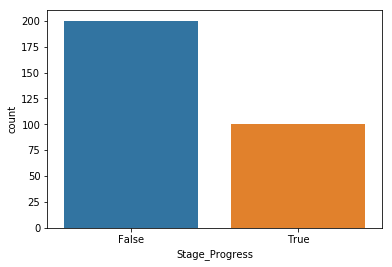

In [8]:
# Check Data balance
sns.countplot(x='Stage_Progress',data=df_stg)
df_stg['Stage_Progress'].value_counts()

Female    176
Male      124
Name: gender, dtype: int64

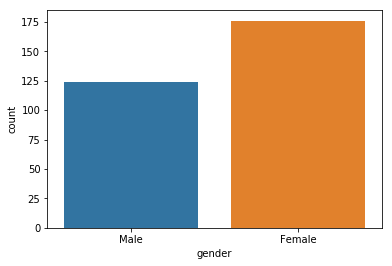

In [9]:
# Gender 
sns.countplot(x='gender',data=df_dem)
df_dem['gender'].value_counts()

White       226
Unknown      26
Black        24
Asian        17
Hispanic      7
Name: race, dtype: int64

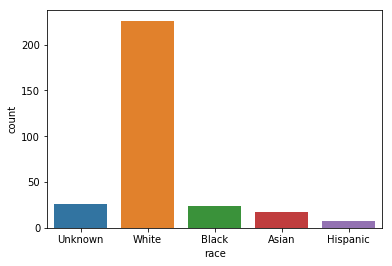

In [10]:
# Ethnicity
sns.countplot(x='race',data=df_dem)
df_dem['race'].value_counts()

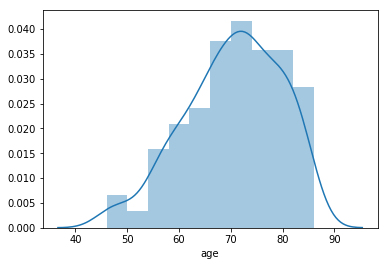

In [11]:
# Age distribution 
sns.distplot(df_dem['age'], bins = 10)

1st mean: 152.11940298507463
2st mean: 119.13609467455622
3st mean: 136.6281847133758
4st mean: 196.73217391304348
5st mean: 177.51925078043703
6st mean: 119.72564612326043


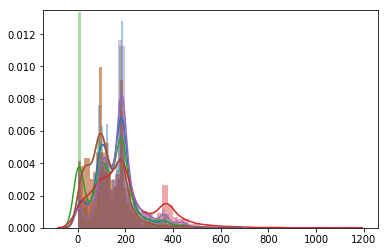

In [12]:
# Plot time intervals between subsequent visits
time_gap_all=[]

for i in range(6):
    time_gap=[]
    for id_ in range(300):
        df_t = idx2df[i][idx2df[i]['id']==id_]
        time_lis = list(df_t['time'])
        time_lis_diff = [time_lis[ind+1] - time_lis[ind] for ind in range(len(time_lis)-1)]
        time_gap+=time_lis_diff
    
    time_gap_all.append(time_gap)
    
for i in range(6):
    sns.distplot(time_gap_all[i], bins=50)
    print('{}st mean: {}'.format(i+1, np.mean(time_gap_all[i])))

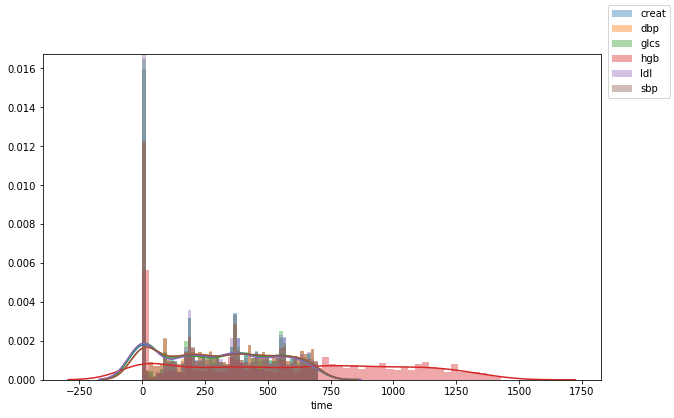

In [13]:
# Plot time for different lab tests
fig = plt.figure(figsize=(10,6))
for i in range(6):
    sns.distplot(idx2df[i]['time'], bins=50)
fig.legend(labels=['creat','dbp','glcs','hgb','ldl','sbp'])
plt.show()

In [14]:
# Only consider hgb values less than 700
df_hgb = df_hgb[df_hgb['time']<700]

# Data Pre-processing

In [15]:
#Create idx mapping for ease
df2idx = {0: df_creat,
         1: df_dbp,
         2: df_glcs,
         3: df_hgb,
         4: df_ldl,
         5: df_sbp}
idx2df = df2idx

In [16]:
# Encode drugs to categories
df_meds["drug"] = df_meds["drug"].astype('category')
drug2idx = dict(enumerate(df_meds['drug'].cat.categories))
df_meds["drug_cat"] = df_meds["drug"].cat.codes
df_meds.head()

,id,drug,daily_dosage,start_day,end_day,drug_cat
0,0,atorvastatin,10.0,19,109,1
1,0,atorvastatin,10.0,117,207,1
2,0,losartan,100.0,19,289,8
3,0,losartan,100.0,403,493,8
4,0,losartan,100.0,587,677,8


In [17]:
# Encode gender to categories
df_dem["gender"] = df_dem["gender"].astype('category')
gender2idx = dict(enumerate(df_dem['gender'].cat.categories))
df_dem["gender_cat"] = df_dem["gender"].cat.codes
df_dem.head()

,id,race,gender,age,gender_cat
0,0,Unknown,Male,70,1
1,1,White,Female,71,0
2,2,White,Female,57,0
3,3,White,Male,74,1
4,4,White,Female,50,0


In [18]:
# Assign bin-size 
BIN_SIZE = 100

In [19]:
# Arrange lab test data in regular time intervals
patients_data = []
for j in range(300):
    patient_data = {key: 6*[0] for key in range(BIN_SIZE,701,BIN_SIZE)}
    for i in range(6):
        temp_df = idx2df[i][idx2df[i]['id']==j]
        for row in temp_df.iterrows():
            day = row[1]['time']
            value = row[1]['value']
            dic_key = (int(day/BIN_SIZE)+1)*BIN_SIZE
            patient_data[dic_key][i] =value 
    patients_data.append(patient_data)    

In [20]:
# Create binary mask vectors to represent missing values for lab tests
mask_vectors = []
for i in range(300):    
    mask = {key: np.zeros([6]) for key in range(BIN_SIZE,701,BIN_SIZE)}   
    for key, value in patients_data[i].items():
        np.where(value!=0)
        ind_1s = (np.where(np.array(value)!=0))
        mask[key][ind_1s] =1
        mask[key] = list(mask[key])
    mask_vectors.append(mask)

In [21]:
# Combine lab test data and the mask vectors
patients_data_comb = []
for i in range(300):
    comb = {key: 6*[0] for key in range(BIN_SIZE,701,BIN_SIZE)}
    for key,values in patients_data[i].items():
        pat_data = values
        mask = mask_vectors[i][key]
        comb[key] = pat_data + mask
    patients_data_comb.append(comb)
       

In [22]:
# Represent medical data in regular intervals depending on the dosage
medic_data= [] 
for id_ in range(300):
    med_data_temp = {key: 21*[0] for key in range(BIN_SIZE,701,BIN_SIZE)}
    df_med_id = df_meds[df_meds['id']==id_]

    for df_id, (i,j) in enumerate(df_med_id.iterrows()):
        med_ind = j['drug_cat']
        start_day = j['start_day']
        end_day = j['end_day']
        dd = j['daily_dosage']
        start_ind = int(start_day/BIN_SIZE)
        end_ind = int(end_day/BIN_SIZE)
        
        if start_ind!=end_ind:
            
            if start_day<0:
                start_key = BIN_SIZE
                start_tdd = dd*abs(start_day)
            else:
                start_key = (start_ind+1)*BIN_SIZE
                start_diff = (start_ind+1)*BIN_SIZE - start_day
                start_tdd = dd*start_diff
                
            end_key = (end_ind+1)*BIN_SIZE
            end_diff = end_day - (end_ind)*BIN_SIZE 
            end_tdd = dd*end_diff

            if start_day<0 and start_key==end_key:
                med_data_temp[start_key][med_ind]+= start_tdd + end_tdd
                continue
                
            for k in range(start_key,end_key+1, BIN_SIZE):
                if k == start_key:
                    med_data_temp[start_key][med_ind]+=start_tdd
                elif k == end_key:
                    med_data_temp[end_key][med_ind]+=end_tdd
                else:
                    med_data_temp[k][med_ind]+=dd*BIN_SIZE
                    
        elif start_ind==end_ind:
            key_both = (start_ind+1)*BIN_SIZE
            diff = end_day - start_day
            tdd = diff*dd
            med_data_temp[key_both][med_ind]+=tdd
            
    medic_data.append(med_data_temp)

In [23]:
# Combine medical data, lab test data and mask vectors
patients_data_combined = []
for i in range(300):
    combined = {key: [] for key in range(BIN_SIZE,701,BIN_SIZE)}
    for key,value in patients_data_comb[i].items():
        lt_dat = value
        med_dat = medic_data[i][key]
        combined[key] = lt_dat+med_dat
    patients_data_combined.append(combined)

In [24]:
# Get age and gender data
demographic_data = []
for i in range(300):
    df_temp = df_dem[df_dem['id']==i]
    age = int(df_temp['age'])
    gender = int(df_temp['gender_cat'])
    demographic_data.append([age, gender])

In [25]:
# Combine static demographic features to sequential features
for i in range(300):   
    patients_data_combined[i] = [patients_data_combined[i]]
    patients_data_combined[i].append(demographic_data[i]) 

In [26]:
# Get the target variable
y = list(map(int, (list(df_stg['Stage_Progress']))))

In [27]:
# Split the data in to training, validation and test sets
X_train, X_test_comb, y_train, y_test_comb = train_test_split(patients_data_combined, 
                                                              y, test_size=0.25, 
                                                              random_state=42, 
                                                              shuffle = True, stratify = y)
X_val, X_test, y_val, y_test = train_test_split(X_test_comb, y_test_comb,test_size=0.50, 
                                                random_state=42, shuffle = True, 
                                                stratify = y_test_comb)

print('length of training set : {}'.format(len(X_train)))
print('length of validation set : {}'.format(len(X_val)))
print('length of test set : {}'.format(len(X_test)))

length of training set : 225
length of validation set : 37
length of test set : 38


In [28]:
# Get mean of features for imputing
ave_dict = {key:[] for key in range(6)}
for i in range(len(X_train)):    
    for key,value in X_train[i][0].items():
        for i in range(6):
             ave_dict[i].append(value[i])
mean_all=[]
for i in range(6):
    tl_arr = np.array(ave_dict[i])
    temp_mean = np.mean(tl_arr[np.where(tl_arr>0)])
    mean_all.append(temp_mean)

print('Lab tests means: ',mean_all)

Lab tests means:  [1.3163607594936708, 79.70439024390244, 6.641035598705502, 13.944690026954177, 86.2538374717833, 134.0312888052681]


In [29]:
# Impute mean in missing data
def impute_mean(X, mean_all):
    for i in range(len(X)):
        for key,value in X[i][0].items():
            for j in range(6):
                if value[j] == 0:
                    X[i][0][key][j] = mean_all[j]
    return X

In [30]:
# Impute mean in missing data
X_train = impute_mean(X_train, mean_all)
X_val = impute_mean(X_val, mean_all)
X_test = impute_mean(X_test, mean_all)

In [31]:
# Filter data to be normalized
data_to_be_norm = []
age_norm = []
for i in range(len(X_train)):
    x = X_train[i]
    for key,value in x[0].items():
        temp = []
        top_6 = value[:6] 
        med_data = value[-21:]
        temp = top_6 + med_data
        data_to_be_norm.append(temp)
    age_norm.append([x[1][0]])

In [32]:
# Fit to training data
scaler = MinMaxScaler()
scaler.fit(data_to_be_norm)
age_scaler = MinMaxScaler()
age_scaler.fit(age_norm)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [33]:
# Function for normalizing 
def normalize_data(X, scaler, age_scaler):
    for i in range(len(X)):
        train = X[i]

        for key, value in train[0].items():
            top_6 = value[:6] 
            med_data = value[-21:]
            temp = np.array([top_6 + med_data])
            norm = list(scaler.transform(temp))
            X[i][0][key][:6] = norm[0][:6]
            X[i][0][key][-21:] = norm[0][-21:]

        age_norm = (age_scaler.transform([[train[1][0]]]))
        X[i][1][0]=age_norm[0][0]
    return X

In [34]:
# Normalize the datasets 
X_train = normalize_data(X_train, scaler, age_scaler)
X_val = normalize_data(X_val, scaler, age_scaler)
X_test = normalize_data(X_test, scaler, age_scaler)

# Modelling

In [35]:
# Define pytorch Dataset class
class Dataset(data.Dataset):
    def __init__(self, samples, labels):
        
        self.samples = samples
        self.labels = labels
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        
        sample = self.samples[idx]
        sample_tensor =[torch.tensor(list(sample[0].values())), 
                                     torch.tensor(sample[1])]
        label_tensor = torch.tensor(int(self.labels[idx]))

        return sample_tensor, label_tensor

In [36]:
# Create out dataset to torch instance
train_dataset = Dataset(X_train, y_train)
val_dataset = Dataset(X_val, y_val)
test_dataset = Dataset(X_test, y_test)

In [37]:
#Pad the varibale length sequences, if any

def my_collate(batch):
    data = [item[0][0] for item in batch]
    dem_data = [item[0][1] for item in batch]
    target = [item[1] for item in batch]

    max_ = 0
    for f in data:
        if len(f)>max_:
            max_ = len(f)

    for ind, d in enumerate(data):
        diff = max_-len(d)
        if diff == 0:
            continue
        else:
            zero_ten = torch.zeros([diff,data[0][0].shape[0]])
            data[ind] = torch.cat((data[ind],zero_ten.double()),0)


    data = torch.stack(data)
    dem_data = torch.stack(dem_data)
    target = torch.tensor(target)
    
    data = data.float()
    dem_data = dem_data.float()

    return [data, dem_data],target 

In [38]:
# Build Dataloader iterators 
BATCH_SIZE = 5
train_dataloader = data.DataLoader(train_dataset, batch_size = BATCH_SIZE, collate_fn=my_collate)
val_dataloader = data.DataLoader(val_dataset, batch_size = BATCH_SIZE, collate_fn=my_collate)
test_dataloader = data.DataLoader(test_dataset, batch_size = BATCH_SIZE, collate_fn=my_collate)


In [39]:
# define model
class classifier(nn.Module):
    #define all the layers used in model
    def __init__(self, input_size, hidden_dim, output_dim, n_layers, 
    bidirectional, dropout):
        #Constructor
        super().__init__()    
    
        #gru layer
        self.lstm = nn.GRU(input_size, 
        hidden_dim, 
        num_layers=n_layers, 
        bidirectional=bidirectional, 
        dropout=dropout,
        batch_first=True)
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        if bidirectional == True:
            self.dir = 2
        else:
            self.dir = 1
        
        #dense layer
        self.fc1 = nn.Linear(hidden_dim * 2+2, hidden_dim)
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, data, seq_lengths):
        
        # Divide into seq and dem data
        seq = data[0]
        dem = data[1]

        packed_embedded = nn.utils.rnn.pack_padded_sequence(seq,
                                                            seq_lengths,batch_first=True)
        packed_output, (hidden) = self.lstm(packed_embedded)
        
        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        
        #concat rnn output with statoc features
        comb_hidden = torch.cat((hidden, dem),dim=1)
        dense_outputs_1=self.fc1(comb_hidden)
        dense_outputs_1 = nn.functional.leaky_relu(dense_outputs_1)
        dense_outputs_1 = self.batch_norm1(dense_outputs_1)
        dense_outputs_1 = nn.functional.dropout(dense_outputs_1, p = 0.6)
        
        dense_outputs_2=self.fc2(dense_outputs_1)

        return dense_outputs_2

In [81]:
# Define model hyperparameters
input_size = 33 #same as number of features
hidden_dim = 8
output_dim = 1
n_layers = 1
bidirectional = True
dropout = 0.0

# Create model
model = classifier(input_size, hidden_dim,output_dim, n_layers, 
                   bidirectional = bidirectional, dropout = dropout)

# optimzer
LEARNING_RATE = 0.0001
base_optim = RAdam(model.parameters(),lr = LEARNING_RATE) 
optimizer =  Lookahead(base_optim, k=5, alpha=0.5)

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3.0))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 90, gamma=0.1, last_epoch=-1)

In [45]:
# Initalize the weights
# model.apply(weight_init)

classifier(
  (lstm): GRU(33, 8, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=18, out_features=8, bias=True)
  (batch_norm1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)

In [82]:
# load weights from the last model
model.load_state_dict(torch.load('saved/models/last_model.pt')['model'], strict = True)


<All keys matched successfully>

Tra_Loss: 0.9181 Tra_Acc: 0.8089 Val_Loss: 1.0084 Val_Acc: 0.7297 f1: 0.6364
Model saved in 0 epoch
Tra_Loss: 0.7241 Tra_Acc: 0.8178 Val_Loss: 1.7070 Val_Acc: 0.7297 f1: 0.6000
Tra_Loss: 0.7603 Tra_Acc: 0.8000 Val_Loss: 1.0962 Val_Acc: 0.7568 f1: 0.6667
Model saved in 10 epoch
Tra_Loss: 0.8022 Tra_Acc: 0.8311 Val_Loss: 1.5161 Val_Acc: 0.7838 f1: 0.7000
Model saved in 15 epoch
Tra_Loss: 0.7103 Tra_Acc: 0.8400 Val_Loss: 1.5433 Val_Acc: 0.7027 f1: 0.5714
Tra_Loss: 0.7238 Tra_Acc: 0.8044 Val_Loss: 1.2754 Val_Acc: 0.7027 f1: 0.6087
Tra_Loss: 0.7553 Tra_Acc: 0.7911 Val_Loss: 1.2777 Val_Acc: 0.7838 f1: 0.7273
Model saved in 30 epoch
Tra_Loss: 0.8321 Tra_Acc: 0.8133 Val_Loss: 1.4996 Val_Acc: 0.7568 f1: 0.6667
Tra_Loss: 0.8489 Tra_Acc: 0.8089 Val_Loss: 1.2851 Val_Acc: 0.7297 f1: 0.6364
Tra_Loss: 0.6429 Tra_Acc: 0.8044 Val_Loss: 0.5497 Val_Acc: 0.7568 f1: 0.7200
Tra_Loss: 0.8415 Tra_Acc: 0.7911 Val_Loss: 1.5416 Val_Acc: 0.6486 f1: 0.5217
Tra_Loss: 0.6522 Tra_Acc: 0.8267 Val_Loss: 1.4925 Val_Acc:

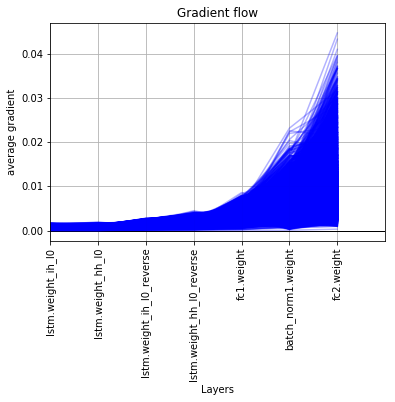

In [83]:
n_epoch =200
f1=0

for epoch in range(n_epoch):
    running_loss = 0
    running_acc = 0
    
    for train_data, train_label in train_dataloader:
        model.train()
        
        with torch.set_grad_enabled(True):
        
            X_len = BATCH_SIZE*[train_data[0].shape[1]]
                
            # Zero the parameter gradients
            optimizer.zero_grad()

            y_pred = model(train_data, X_len)
            
            y_pred = y_pred.view(BATCH_SIZE)
            loss = criterion(y_pred,train_label.float())
            
            y_pred_sig = (torch.sigmoid(y_pred).data > 0.5).float()

            #backpropage the loss and compute the gradients
            loss.backward()
            
            # grad clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
            # plot the grad
            plot_grad_flow(model.named_parameters())

            #update the weights
            optimizer.step()
            scheduler.step()

        rounded_preds = torch.round(y_pred_sig)
        running_loss += loss.item() * train_data[0].size(0)
        running_acc += torch.sum(rounded_preds == train_label.float()).item()
        
    epoch_loss = running_loss/len(train_dataset)
    epoch_acc = running_acc/len(train_dataset)

    if epoch%5 == 0:

        running_val_acc = 0
        running_val_loss = 0
        val_pred=[]
        val_true=[]
        
        for val_data, val_label in val_dataloader:    
            model.eval()
            with torch.set_grad_enabled(False):

                if len(val_data[0])<BATCH_SIZE:
                    continue

                X_len = BATCH_SIZE*[val_data[0].shape[1]]

                # Zero the parameter gradients
                optimizer.zero_grad()

                y_pred = model(val_data, X_len)
                y_pred = y_pred.view(BATCH_SIZE)
                
                val_loss = criterion(y_pred,val_label.float())
                
                y_pred_sig = (torch.sigmoid(y_pred).data > 0.5).float()

            rounded_preds = torch.round(y_pred_sig)
            running_val_loss += val_loss.item() * val_data[0].size(0)
            running_val_acc += (rounded_preds == val_label.float()).sum().item()

            val_pred += list(rounded_preds.numpy())
            val_true += list(val_label.numpy())

        epoch_val_loss = running_val_loss/len(val_dataset)
        epoch_val_acc = running_val_acc/len(val_dataset)
        
        if len(np.unique(val_pred))>1:
            curr_f1_score = f1_score(val_true, val_pred)
        else:
            curr_f1_score =0

        print('Tra_Loss: {:.4f} Tra_Acc: {:.4f} Val_Loss: {:.4f} Val_Acc: {:.4f} f1: {:.4f}'.format(
            epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc, curr_f1_score))
    
        # Save model wts for highest F1 score for validation set
        if curr_f1_score > f1:
            f1 = curr_f1_score
            best_model_wts = copy.deepcopy(model.state_dict())
            print('Model saved in {} epoch'.format(epoch))
      

In [93]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [94]:
#save the model
checkpoint = { 'model': best_model_wts }
torch.save(checkpoint, 'models/model.pt')